In [ ]:
# @title 🚀 Setup (Run this cell first!)
import os
import sys

# 1. Detect if we are in Google Colab
if 'google.colab' in sys.modules:
    print("Running in Google Colab. Setting up environment...")
    
    # 2. Define the source of your data files 
    BASE_URL = "https://raw.githubusercontent.com/fhfarnoud/intro2ml/main/2026S/data/"
    
    # 3. List the files you need
    files_to_download = ['NBA_player_data.csv']
    
    # 4. Download the files
    if not os.path.exists('data'):
        os.makedirs('data')
        
    for filename in files_to_download:
        if not os.path.exists(f"data/{filename}"):
            url = f"{BASE_URL}{filename}"
            print(f"Downloading {filename}...")
            !wget -q -O data/{filename} {url}
            
    print("✅ Setup complete! Data files are ready.")
else:
    print("Running locally. Assuming data is already present.")


# Lecture 3: kNN Implementation & Real Datasets

**ECE 2410 - Introduction to Machine Learning**  
**Spring 2026**

---

## Building on Lecture 2

In L02, you learned:
- Euclidean distance using `np.linalg.norm()`
- 1-Nearest Neighbor on a small toy dataset
- Using for loops to classify test points

**Today we'll extend this to:**
1. Real datasets with hundreds/thousands of samples
2. Proper train/test splitting
3. Feature normalization
4. k-NN (majority vote among k neighbors)
5. MNIST digit classification



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# NEW: pandas is a library for loading and manipulating tabular data (like spreadsheets)
import pandas as pd

# NEW: sklearn has built-in datasets and ML utilities
from sklearn.datasets import fetch_openml


np.random.seed(42)

---
## Python Concepts You'll Need Today

Before diving into the main content, let's quickly review some Python/NumPy concepts we'll use.

In [2]:
# --- 1. Random Seed for Reproducibility ---
# Computers generate "pseudo-random" numbers starting from a "seed".
# By fixing this seed (e.g., to 42), we ensure that every time we run this notebook,
# we get exactly the same random shuffles and splits. Use this for debugging!
#
# Note: If you run a cell multiple times, you may get different results unless you reset the seed.
# IMPORTANT: "Restart Kernel and Run All" to see what we will see when grading!

np.random.seed(0)
print("With seed 0:", np.random.randint(0, 100, 5))
print("Again:      ", np.random.randint(0, 100, 5))  # Different! Seed not reset

np.random.seed(0)  # Reset to same seed
print("Reset seed: ", np.random.randint(0, 100, 5))  # Same as first output!

With seed 0: [44 47 64 67 67]
Again:       [ 9 83 21 36 87]
Reset seed:  [44 47 64 67 67]


In [3]:
# --- 2. Functions with Multiple Return Values ---
# A function can return multiple values as a tuple.
# You can "unpack" them directly into separate variables.

def get_stats(arr):
    return np.min(arr), np.max(arr), np.mean(arr)

data = np.array([1, 5, 3, 9, 2])

# Unpack the 3 returned values into 3 variables:
min_val, max_val, mean_val = get_stats(data)
print(f"Min: {min_val}, Max: {max_val}, Mean: {mean_val}")

Min: 1, Max: 9, Mean: 4.0


In [4]:
# --- 3. The axis Parameter ---
# For 2D arrays: axis=0 means "down columns", axis=1 means "across rows"

X = np.array([[1, 2, 3],
              [4, 5, 6]])
print("X =")
print(X)
print()
print("Sum all:", np.sum(X))           # 21 (everything)
print("Sum axis=0:", np.sum(X, axis=0))  # [5, 7, 9] (down columns)
print("Sum axis=1:", np.sum(X, axis=1))  # [6, 15] (across rows)

X =
[[1 2 3]
 [4 5 6]]

Sum all: 21
Sum axis=0: [5 7 9]
Sum axis=1: [ 6 15]


In [5]:
# --- 4. Reshape ---
# Convert between 1D vectors and 2D arrays (crucial for images!)

# A 1D vector of 12 elements
vec = np.arange(12)
print("1D vector:", vec)

# Reshape to 3x4
matrix = vec.reshape(3, 4)
print("\nReshaped to 3x4:")
print(matrix)

# Reshape back to 1D
flat = matrix.reshape(-1)  # -1 means "figure out the size"
print("\nFlattened back:", flat)

1D vector: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Reshaped to 3x4:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

Flattened back: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [6]:
# --- 5. Views vs Copies (Important!) ---
# Basic slicing creates a VIEW (shares memory with original)
# Fancy indexing creates a COPY (independent)

original = np.array([1, 2, 3, 4, 5])

# VIEW: basic slicing
view = original[:3]
view[0] = 999
print("After modifying view:", original)  # Original is also changed!

# COPY: fancy indexing (using a list or array of indices)
original = np.array([1, 2, 3, 4, 5])
indices = [0, 1, 2]
copy = original[indices]
copy[0] = 999
print("After modifying copy:", original)  # Original unchanged!

# Tip: Use .copy() if you want to be explicit
safe_copy = original[:3].copy()

After modifying view: [999   2   3   4   5]
After modifying copy: [1 2 3 4 5]


---
## Part 1: NBA Player Classification (Full Dataset)

In L02, we used just 4 training players. Now let's use the **full NBA dataset**!

**Task**: Classify NBA players as Guards vs. Forwards/Centers based on height and weight.

### 1.1 Load the NBA Dataset

**NEW: `pd.read_csv()`** - Loads data from a CSV file into a DataFrame (like a spreadsheet).

In [7]:
# Load NBA data from CSV file
nba_df = pd.read_csv('data/NBA_player_data.csv')
print(f"Dataset has {len(nba_df)} rows")
nba_df.head()  # Show first 5 rows

Dataset has 4550 rows


,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [8]:
# GOOGLE COLAB SETUP
# OPTION 1: Mount Google Drive
# ---------------------------
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/Your/Notebook/Path/Here"
# 
# OPTION 2: Upload Data File
# ---------------------------
# If you prefer not to mount your drive, you can upload the data file manually.
# The code below will upload file and move it to the correct folder.
# 
# from google.colab import files
# import os
# uploaded = files.upload()
# if not os.path.exists('data'):
#     os.makedirs('data')
# !mv NBA_player_data.csv data/
# 
# Check if data exists
# Use !ls data to check if you can see 'NBA_player_data.csv'

### 1.2 Data Preprocessing

Real data often needs cleaning. Here we:
1. Convert height from "6-8" format to inches
2. Remove players with missing data
3. Simplify to 2 classes: Guard vs Forward/Center

In [9]:
# Function to convert height string "6-8" to total inches
def height_to_inches(h):
    try:
        parts = [int(p) for p in h.split('-')]  # Split "6-8" into [6, 8]
        ### BEGIN SOLUTION
        feet = parts[0]
        inches = parts[1]
        return feet * 12 + inches
        ### END SOLUTION
    except:
        return 0

print(f"Example: '6-8' = {height_to_inches('6-8')} inches")

Example: '6-8' = 80 inches


In [10]:
# Clean the data using a simple loop
nba_df = nba_df.dropna(subset=['weight', 'height'])  # Remove missing values

# Convert heights using a loop (clear and simple!)
height_inches = []
for h in nba_df['height']:
    height_inches.append(height_to_inches(h))
nba_df['height_inches'] = height_inches

# Remove invalid heights
nba_df = nba_df[nba_df['height_inches'] > 0]

# Create binary classes using a loop
classes = []
for pos in nba_df['position']:
    if pos == 'G':
        classes.append('Guard')
    elif pos in ['F', 'C', 'F-C', 'C-F']:
        classes.append('Forward/Center')
    else:
        classes.append('Other')
nba_df['class'] = classes

### BEGIN SOLUTION
nba_df = nba_df[nba_df['class'] != 'Other']
### END SOLUTION

print(f"Final dataset: {len(nba_df)} players")

Final dataset: 3968 players


In [11]:
# Extract features (X) and labels (y) as numpy arrays
X = np.column_stack([nba_df['height_inches'].values, nba_df['weight'].values])
y = (nba_df['class'] == 'Forward/Center').astype(int).values  # 0=Guard, 1=Fwd/Ctr

print(f"Features X: {X.shape}  (samples × features)")
print(f"Labels y: {y.shape}")

Features X: (3968, 2)  (samples × features)
Labels y: (3968,)


### 1.3 Train/Test Split

**NEW: `np.random.permutation(N)`** - Returns shuffled indices [0, 1, ..., N-1]

In [12]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    """Split data into training and test sets."""
    np.random.seed(random_state)
    
    N = len(y)
    n_test = int(N * test_size)
    
    # NEW: shuffle indices randomly
    indices = np.random.permutation(N)
    
    ### BEGIN SOLUTION
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    ### END SOLUTION

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(f"Train: {len(y_train)}, Test: {len(y_test)}")

Train: 3175, Test: 793


### 1.4 Feature Normalization

**NEW: `np.std()`** - Computes standard deviation (measures spread of data)

In [13]:
def normalize_zscore(X_train, X_test):
    """Z-score: (x - mean) / std. Use TRAINING stats for both!"""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)  # NEW: standard deviation
    
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std  # Use training stats!
    return X_train_norm, X_test_norm

X_train_norm, X_test_norm = normalize_zscore(X_train, X_test)
print(f"Normalized mean: {np.mean(X_train_norm, axis=0).round(4)}")
print(f"Normalized std:  {np.std(X_train_norm, axis=0).round(4)}")

Normalized mean: [0. 0.]
Normalized std:  [1. 1.]


### 1.5 k-NN Implementation

Uses `np.linalg.norm()` and `np.argsort()` from L02.

In [14]:
def knn_predict(X_train, y_train, X_test, k=3):
    """k-Nearest Neighbors prediction."""
    predictions = []
    
    for x_test in X_test:
        # Distance to all training points (from L02!)
        distances = np.linalg.norm(X_train - x_test, axis=1)
        
        ### BEGIN SOLUTION
        # Find k nearest (argsort returns sorted indices)
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]
        
        # Majority vote: count how many of each class
        count_class_0 = np.sum(k_nearest_labels == 0)
        count_class_1 = np.sum(k_nearest_labels == 1)
        
        # Predict the class with more votes
        if count_class_1 > count_class_0:
            prediction = 1
        else:
            prediction = 0
        ### END SOLUTION
        predictions.append(prediction)
    
    return np.array(predictions)

y_pred = knn_predict(X_train_norm, y_train, X_test_norm, k=5)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 88.52%


### 1.6 Precision and Recall

**Accuracy** can be misleading with imbalanced classes. Let's also compute:
- **Precision**: Of all predicted positives, how many are correct?
- **Recall**: Of all actual positives, how many did we find?

For our NBA data: Positive class = Forward/Center (label 1)

In [15]:
def compute_metrics(y_true, y_pred):
    """Compute accuracy, precision, and recall."""
    # True Positives, False Positives, False Negatives, True Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    ### BEGIN SOLUTION
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    ### END SOLUTION
    
    return accuracy, precision, recall

acc, prec, rec = compute_metrics(y_test, y_pred)
print(f"Accuracy:  {acc:.2%}")
print(f"Precision: {prec:.2%}  (of predicted Fwd/Ctr, how many correct?)")
print(f"Recall:    {rec:.2%}  (of actual Fwd/Ctr, how many did we find?)")

Accuracy:  88.52%
Precision: 94.50%  (of predicted Fwd/Ctr, how many correct?)
Recall:    86.01%  (of actual Fwd/Ctr, how many did we find?)


---
## Part 2: MNIST Digit Classification

**Key Concept**: Images are vectors! A 28×28 image = 784-dimensional vector.

In [16]:
# Load MNIST
print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist.data.astype(np.float32)
y_mnist = mnist.target.astype(np.int32)
print(f"Shape: {X_mnist.shape}  (28×28 = 784 pixels per image)")

Loading MNIST...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Shape: (70000, 784)  (28×28 = 784 pixels per image)


### 2.1 Visualize: Vector → Image

**NEW: `arr.reshape(28, 28)`** - Changes shape from (784,) to (28, 28) for display

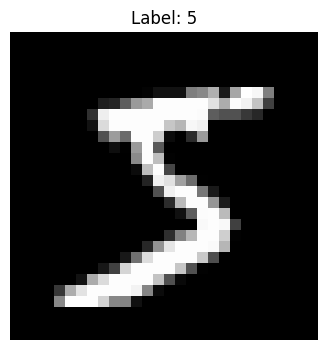

In [17]:
# Display first digit
img_vector = X_mnist[0]  # 784-element vector
img_2d = img_vector.reshape(28, 28)  # NEW: reshape to 2D

plt.figure(figsize=(4, 4))
plt.imshow(img_2d, cmap='gray')
plt.title(f'Label: {y_mnist[0]}')
plt.axis('off')
plt.show()

In [18]:
# Prepare subset (full dataset is too slow for k-NN)
X_train_mnist = X_mnist[:5000] / 255.0  # Normalize to [0,1]
y_train_mnist = y_mnist[:5000]
X_test_mnist = X_mnist[60000:61000] / 255.0
y_test_mnist = y_mnist[60000:61000]

print(f"Train: {X_train_mnist.shape}, Test: {X_test_mnist.shape}")

Train: (5000, 784), Test: (1000, 784)


In [19]:
def knn_multiclass(X_train, y_train, X_test, k=3):
    """k-NN for multi-class (10 digits)."""
    predictions = []
    
    for i, x_test in enumerate(X_test):
        if i % 100 == 0:
            print(f"Processing {i}/{len(X_test)}...", end='\r')
        
        # Step 1: Compute distances to all training points
        distances = np.linalg.norm(X_train - x_test, axis=1)
        
        # Step 2: Find the k nearest neighbors' labels
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]
        
        # Step 3: Count votes for each digit (0-9)
        vote_counts = np.zeros(10, dtype=int)  # 10 possible digits
        ### BEGIN SOLUTION
        for label in k_nearest_labels:
            vote_counts[label] += 1
        
        # Step 4: Predict the digit with the most votes
        prediction = np.argmax(vote_counts)
        ### END SOLUTION
        predictions.append(prediction)
    
    print("Done!" + " "*20)
    return np.array(predictions)

print("Running k-NN (this takes ~1 minute)...")
y_pred_mnist = knn_multiclass(X_train_mnist, y_train_mnist, X_test_mnist, k=3)
print(f"MNIST Accuracy: {np.mean(y_pred_mnist == y_test_mnist):.2%}")

Running k-NN (this takes ~1 minute)...
Done!                    
MNIST Accuracy: 90.90%


### 2.3 Misclassified Examples

Let's see which digits kNN got wrong. This helps us understand the model's limitations.

Number of misclassified: 91 out of 1000


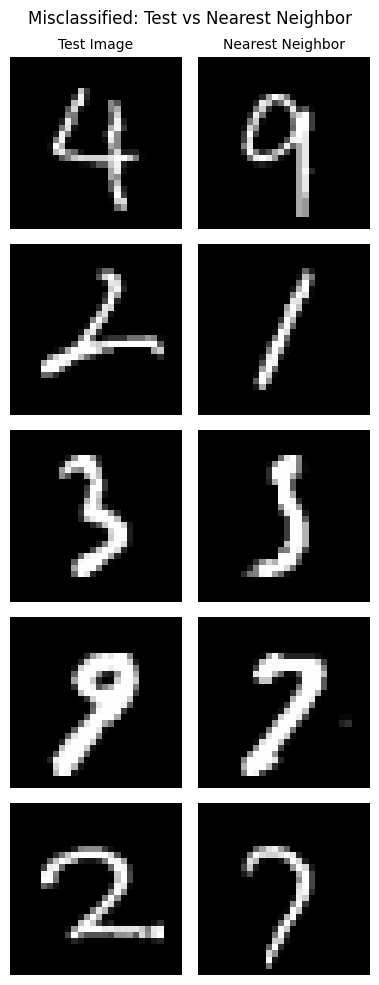

In [20]:
# Find misclassified examples
misclassified_idx = np.where(y_pred_mnist != y_test_mnist)[0]
print(f"Number of misclassified: {len(misclassified_idx)} out of {len(y_test_mnist)}")

# Display misclassified examples with their closest training image
n_show = 5
fig, axes = plt.subplots(n_show, 2, figsize=(4, 10))
axes[0, 0].set_title('Test Image', fontsize=10)
axes[0, 1].set_title('Nearest Neighbor', fontsize=10)

for row in range(n_show):
    if row < len(misclassified_idx):
        idx = misclassified_idx[row]
        
        # Test image (misclassified)
        test_img = X_test_mnist[idx].reshape(28, 28)
        axes[row, 0].imshow(test_img, cmap='gray')
        axes[row, 0].set_ylabel(f'True: {y_test_mnist[idx]}', fontsize=9)
        
        # Find the closest training image
        distances = np.linalg.norm(X_train_mnist - X_test_mnist[idx], axis=1)
        closest_idx = np.argmin(distances)
        closest_img = X_train_mnist[closest_idx].reshape(28, 28)
        axes[row, 1].imshow(closest_img, cmap='gray')
        axes[row, 1].set_ylabel(f'Label: {y_train_mnist[closest_idx]}', fontsize=9)
    
    axes[row, 0].axis('off')
    axes[row, 1].axis('off')

plt.suptitle('Misclassified: Test vs Nearest Neighbor', fontsize=12)
plt.tight_layout()
plt.show()